# ガウス過程（Gaussian Process）

ガウス過程（Gaussian Process, GP）は、関数の分布を扱うベイズ的なモデルである。主に回帰、ベイズ最適化などで利用される。

特に以下では、関数の回帰を行う関数の分布を推定・生成する方法としての観点から解説する。

理論的な詳細等については下記のガウス過程の名著(通称: GPML)を参照されたい。著者のページから無償でPDFが入手可能である:  
["Gaussian Processes for Machine Learning" by Carl Edward Rasmussen and Christopher K. I. Williams](https://gaussianprocess.org/gpml/)


## モチベーション



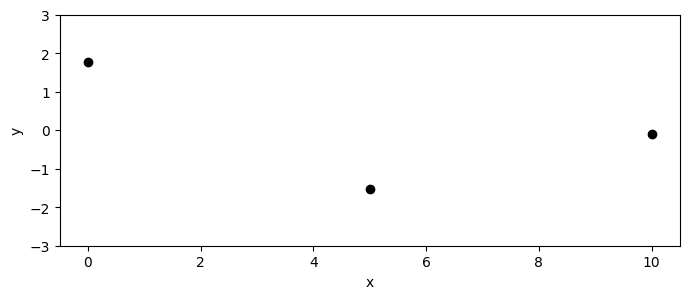

In [1]:
import numpy as np
import matplotlib.pyplot as plt
def f(x):
    return 2*np.sin(x) + np.random.normal(0, 1, x.shape)
np.random.seed(0)
x = np.linspace(0, 10, 3)
y = f(x)
fig = plt.figure(figsize=(8, 3))
plt.scatter(x, y, color="k")
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-3, 3)
plt.show()
plt.close()


今、図のようにデータが観測されているとする。このデータを説明する関数は無数に存在する。
そんな中、単一の関数を選ぶのではなく、「もっともらしい」関数の分布を考えることができれば、より柔軟にデータを説明できると考えられる。

ガウス過程は、このような関数の分布を直接扱うための枠組みの１つである。
背後にある考え方については、以下のとおりである。

1. 任意の近傍二点に対して、その点での関数値は似ている(≒連続)であろう。
2. "似ている"度合いを非負の値を持つカーネル関数で定量化する。
3. 既知のデータと未知の点での関数値の同時分布を考え、それが多変量ガウス分布に従うと仮定する。

とくに最後の点がガウス過程の名前の由来であると理解してもらってよい。

## ガウス過程の定義

観測データが $\mathcal{D} = \{(\mathbf{x}_i, y_i)\}_{i=1}^{n}$ で与えられるとする。ここで、$\mathbf{x}_i \in \mathbb{R}$ は説明変数、$y_i \in \mathbb{R}$ は目的変数である。
説明変数・関数値とも、多次元でも構わないが、ここでは単純化のために1次元としよう。

自分の興味のある$m$個の点 $\mathbf{x}^* $ に対して、関数値 $\mathbf{y}^*$ を予測したいとする。
このときの$\mathbf{x}^* = \{x_1^*, x_2^*, \ldots, x_m^*\}$ は、観測データ $\mathcal{D}$ の説明変数 $\mathbf{x}_i$ (データ点)とは異なる点であるとし、予測点とでも呼ぶことにする。

そのとき、$\mathbf{x}, \mathbf{x}^*$ に対する関数値 $\mathbf{y}, \mathbf{y}^*$ の同時分布が以下のように多変量ガウス分布に従うと仮定する。

$$
\begin{pmatrix}
\mathbf{y} \\ \mathbf{y}^*
\end{pmatrix}
\sim \mathcal{N} \left(
\begin{pmatrix}
\mu_\mathbf{x} \\
\mu_{\mathbf{x}^*}
\end{pmatrix},
\begin{pmatrix}
K(\mathbf{x}, \mathbf{x}) & K(\mathbf{x}, \mathbf{x}^*) \\
K(\mathbf{x}^*, \mathbf{x}) & K(\mathbf{x}^*, \mathbf{x}^*)
\end{pmatrix}
\right)
\equiv \mathcal{N} \left( \boldsymbol{\mu}, \Sigma \right)
$$

:::{margin}
平均ベクトルと共分散行列は、データ点と予測点を合わせて$n+m$次元のベクトル・行列としてまとめて書いた.
:::
ひとたび多次元正規分布の平均ベクトルと共分散行列が与えられれば、条件付き分布もまた多次元正規分布になるため、
以下のように、予測点での関数値の分布を得ることができる。

$$
p(\mathbf{y}^*|\mathbf{y})
= \mathcal{N}\left(
\mu_{\mathbf{x}^*} + K(\mathbf{x}^*, \mathbf{x}) K(\mathbf{x}, \mathbf{x})^{-1} (\mathbf{y} - \mu_{\mathbf{x}}), K(\mathbf{x}^*, \mathbf{x}^*) - K(\mathbf{x}^*, \mathbf{x}) K(\mathbf{x}, \mathbf{x})^{-1} K(\mathbf{x}, \mathbf{x}^*)
\right)
$$

多次元正規分布の条件付き確率分布の計算(3章)を用いた。
この意味するところは、予測点での関数値 $\mathbf{y}^*$ は、観測データ $\mathcal{D}$ に基づいて平均と分散が決定される正規分布に従う、ということである。
それぞれの予測点での関数値が分布に従うため、予測点での関数値の不確実性を考慮することができる。

## カーネルとハイパーパラメータ
カーネル関数 $k(x, x')$ は、関数の滑らかさや周期性などの事前知識を反映する。代表的なカーネルは以下の通りである：

- RBF（ガウス）カーネル: 

    $$
    k(x, x') = \tau \exp\left(-\frac{(x-x')^2}{2l^2}\right)
    $$

    ハイパーパラメータ：$\tau$（出力のスケール）、$l$（長さ尺度, 相関長:correlation lengthとも言う）

- Maternカーネル:

    $$
    k(x, x') = \tau \frac{2^{1-\nu}}{\Gamma(\nu)} \left( \sqrt{2\nu} \frac{|x-x'|}{l} \right)^\nu K_\nu \left( \sqrt{2\nu} \frac{|x-x'|}{l} \right)
    $$

    ここで、$K_\nu$ は第$\nu$種の変形ベッセル関数、$\Gamma(\nu)$ はガンマ関数である。

    ハイパーパラメータ：$\tau$（出力のスケール）、$l$（長さ尺度）、$\nu$（平滑度）

    なかでも$\nu=3/2$や$\nu=5/2$がよく使われる。$\nu=1/2$のときは、指数カーネルとなり、$\nu \to \infty$のときはRBFカーネルとなる。
    RBFカーネルは無限回微分可能で非常に滑らかであるのに対し(それはデータが持つ連続性としては過剰な仮定と考えられ)、Maternカーネルは$\nu$によって微分可能な回数が制御される。
    実用上においても、RBFカーネルで距離の近いデータ点を取りすぎると、数値的に不安定になることがある。

ハイパーパラメータは、対数尤度最大化などで推定されることが多い。
また、カーネルが持つべき重要な性質としては、

- 対称性: $k(x, x') = k(x', x)$
- 正定値性: 任意の異なる点 $\{x_1, x_2, \ldots, x_n\}$ に対して、対応するカーネル行列 $K$ が正定値行列であること
- 非負性: $k(x, x) \geq 0$ であること

が挙げられる。


## ベイズ最適化

ガウス過程は、ベイズ最適化の核としても広く使われる。
関数の振る舞いをガウス過程でモデル化し、その不確実性を考慮しながら最適化を進めていく。

とくに、１回の観測(や数値実験など)にコストがかかり、勾配が利用できないような関数の最適化に有効である。
また、探索と活用のトレードオフを考慮しながら、効率的に最適解に近づくことができることも多く
機械学習のハイパーパラメータチューニングなどにも利用される。
探索というのは「井の中の蛙状態が怖いので、未知の領域を探索してみよう」というイメージで、
活用というのは「今までの経験から良さそうなところを掘り下げてみよう」というイメージである。

例えば今の関数の振る舞いを、パラメータ空間に対するコスト関数だと考え、その最小化や最大化を目指すとする。
すでに得られているデータ点をもとに、次に評価する点を獲得関数で決定する。
言い換えると、情報利得が高そうかつ、良さそうな点を次に評価するための、戦略を立てるための枠組みとも言える。


In [3]:
#使うライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import special
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## データの生成用関数
def f(x):
    return np.sin(x) + 0.2 * x

## ガウス過程のカーネル(共分散行列)の設計
def Mat52(Thetas,r):
    tau,sigma = Thetas
    thetar = r * np.sqrt(5.0)/sigma
    return tau * (1.0 + thetar + (thetar**2) /3.0) * np.exp(-thetar)
def KernelMat(Thetas,xt,xp):
    lt = len(xt); lp=len(xp)
    Ktt = np.zeros((lt,lt)); Kpt = np.zeros((lp,lt));  Kpp = np.zeros((lp,lp))
    for j in range(lt):
        for i in range(j,lt):
            r = abs(xt[i]-xt[j])
            tmp  = Mat52(Thetas,r) 
            Ktt[i,j] = tmp; Ktt[j,i] = tmp 
        for i in range(lp):
            r= abs(xp[i]-xt[j])
            Kpt[i,j] = Mat52(Thetas,r)
    for j in range(lp):
        for i in range(j,lp):
            r= abs(xp[i]-xp[j])
            tmp  = Mat52(Thetas,r)
            Kpp[i,j] = tmp; Kpp[j,i] = tmp
    return Ktt,Kpt,Kpp

## 事後共分散行列の計算
def calcSj(cLinv,Kpt,Kpp,yt,mu_yt,mu_yp):
    tKtp= np.dot(cLinv,Kpt.T)
    return mu_yp + np.dot(Kpt,np.dot(cLinv.T,np.dot(cLinv,yt-mu_yt))), Kpp - np.dot(tKtp.T,tKtp)

## Cholesky分解
def Mchole(tmpA,ln) :
    cLL = np.linalg.cholesky(tmpA)
    logLii=0.0
    for i in range(ln):
        logLii += np.log(cLL[i,i])
    return np.linalg.inv(cLL), 2.0*logLii

## 獲得関数を計算, 次点の計算点を決める
def calcEI(xp,mujoint,sigmaj,xbest,ybest):
    EIs = [ (mujoint[i]-ybest) * Phi((mujoint[i]-ybest)/sigmaj[i]) +
            sigmaj[i]* np.exp(-0.5* ((mujoint[i]-ybest)/sigmaj[i])**2) for i in range(len(xp))]
    xnew,ynew,ind=xybest(xp,EIs)
    ynew= np.sin(xnew) + 0.2*xnew #+ 0.01 * (0.5-np.random.rand())
    return xnew,ynew,EIs,ind
def Phi(z):
    return 0.5 * special.erfc(-(z/(2**0.5)) )

def xybest(xt,yt):
    ind = np.argmax(yt)
    return xt[ind],yt[ind],ind

def plotGP(nxt,nyt,nxp,xp,ytrue,mujoint,sigmaj,ysamples,EIs):
    fig = plt.figure(figsize=(10, 4))
    axT = fig.add_subplot(121)
    axB = fig.add_subplot(122)
    axT.set_xlabel("x"); axT.set_ylabel("y")
    axB.set_xlabel("x"); axB.set_ylabel("Acquisition function")
    axT.set_xlim(-2.0,12); axT.set_ylim(-2.0,5.0)
    axB.set_xlim(-2.0,12)
    axT.scatter(nxt,nyt,marker="o",color="black",label="Data")
    for i in range(len(ysamples)):
        axT.plot(nxp,ysamples[i],alpha=0.1)
    axT.plot(nxp,mujoint,label="GP mean",linestyle="dashed",color="blue")
    axB.plot(nxp,EIs,color="green")
    axB.set_yticklabels([]) 
    axT.fill_between(nxp,mujoint-sigmaj,mujoint+sigmaj,color="blue", alpha=0.3)
    axT.plot(xp,ytrue,color="red",label="True",linestyle="dotted")
    axT.legend(loc="upper right")
    plt.show()
    plt.close()

Thetas=[2.0,2.0]
oxt = np.array([ 0.0 + 1.02*i for i in range(11)])
xp = []
for tmp in np.arange(-2.0,12.0, 5.e-2):
    if (tmp in oxt)==False:
        xp += [ tmp ]
xp = np.array(xp)
oyt = f(oxt)
ytrue = f(xp)

SVs=[]
xt =[oxt[2],oxt[6]]; yt =[oyt[2],oyt[6]]
nxp = list(copy.copy(xp))
nxt = copy.copy(xt)
nyt = copy.copy(yt)

n_iter = 10 ## 探索回数の上限
xopt = 6; yopt = -1.e+30

## お絵かき
fig = plt.figure(figsize=(10,4))
axT = fig.add_subplot(121)
axB = fig.add_subplot(122)

scatter = axT.scatter(nxt, nyt, s=10, alpha=0.5)
title = axB.set_title("")

def plotGP(iter):
    nxt, nyt, nxp, mujoint, sigmaj, ysamples, EIs, xnew = snapshots[iter]
    axT.clear()
    axB.clear()
    axT.set_xlabel("x"); axT.set_ylabel("y")
    axB.set_xlabel("x"); axB.set_ylabel("Acquisition function")
    axT.set_xlim(-2.0,12); axT.set_ylim(-2.0,5.0)
    axB.set_xlim(-2.0,12)
    axT.scatter(nxt,nyt,marker="o",color="black",label="Data")
    axT.vlines(xnew, -2.0, 5.0, lw=3, colors="gray", linestyles="dotted", label="Next point")
    axB.vlines(xnew, 0.0, max(EIs), lw=3, colors="gray", linestyles="dotted")
    for i in range(len(ysamples)):
        axT.plot(nxp,ysamples[i],alpha=0.1)
    axT.plot(nxp,mujoint,label="GP mean",linestyle="dashed",color="blue")
    axB.plot(nxp,EIs,color="green")
    axB.set_yticklabels([]) 
    axT.fill_between(nxp,mujoint-sigmaj,mujoint+sigmaj,color="blue", alpha=0.3)
    axT.plot(xp,ytrue,color="red",label="True",linestyle="dotted")
    axT.legend(loc="upper right")

snapshots = [ ]
for iter in range(n_iter):
    lt=len(nxt); lp=len(nxp)
    Ktt,Kpt,Kpp = KernelMat(Thetas,nxt,nxp)
    mu_yt= np.zeros(lt)
    mu_yp= np.zeros(lp)
    cLinv,logdetK = Mchole(Ktt,lt) 
    mujoint,Sjoint = calcSj(cLinv,Kpt,Kpp,nyt,mu_yt,mu_yp)
    sigmaj=[ Sjoint[j][j] for j in range(lp)]
    ysamples = [np.random.multivariate_normal(mujoint,Sjoint) for i in range(10)]
    SVs += [ [ mujoint, sigmaj] ]
    xbest,ybest,ind= xybest(nxt,nyt)
    xnew,ynew,EIs,ind = calcEI(nxp,mujoint,sigmaj,xbest,ybest)
    snapshots += [ [nxt.copy(), nyt.copy(), nxp.copy(), 
                    mujoint.copy(), sigmaj.copy(), ysamples.copy(), EIs.copy(),
                    xnew] ]
    # 次点のための操作 (データ点の追加と候補の削除)
    nxt += [ xnew ]; nyt += [ ynew ]
    nxp.pop(ind)    
    if ynew > yopt:
        xopt= xnew; yopt = ynew 

anim = FuncAnimation(fig, plotGP, frames=n_iter, interval=1000)
plt.close(fig)
display(HTML(anim.to_jshtml()))